In [682]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad as autograd_grad
import random
import time

random_seed = 35 # if you change random seed you should be careful about etas and convergence of each method.
random.seed(random_seed) #We've chosen a matrix for which each method at least works, for better matrixes some methods show superlinear convergence
np.random.seed(random_seed) #We consentrated on accelerated method so here you can see superlinear convergence of it

In [683]:
def generate_synthetic_data(n, sigma):
    C = 0.01 * np.random.randn(n, n) + np.eye(n)
    D = np.diag(np.random.uniform(0, 1, n))
    A = np.dot(C, np.dot(D, C.T)) + sigma * np.eye(n)  # A = CDC^T + sigma*I
    b = np.random.uniform(0, 1, n)
    return A, b

def least_squares_function(x, A, b):
    return 0.5 * np.linalg.norm(np.dot(A, x) - b)**2

def gradient_least_squares(x, A, b):
    return np.dot(A.T, np.dot(A, x) - b)

n = 100
sigmas = [1e-2, 1e-1, 0.2]


datasets = []
for sigma in sigmas:
    A, b = generate_synthetic_data(n, sigma)
    datasets.append((A, b, sigma))

A, b, sigma = datasets[1]

ATA = np.dot(A.T, A)
L = np.linalg.eigvalsh(ATA).max()
mu = np.linalg.eigvalsh(ATA).min()
kappa = L / mu

learning_rate_gd = 2 / (L + mu)
x_star = np.linalg.solve(ATA, np.dot(A.T, b))
f_star = least_squares_function(x_star, A, b)

x_init = np.random.randn(n)
x_init = x_init / np.linalg.norm(x_init)
K = 10000

eta_1 = 1/(4*L**2)
eta_candidates_osgm_r = [ 25] # one can add parameters but for the picture we've chosen the good ones
eta_candidates_osgm_g = [ 15]
eta_candidates_osgm_h = [ 1.4]
eta_candidates_osgm_r_accelerated = [25]
A_inv = np.linalg.inv(A)
P_ini = np.linalg.inv(ATA)
P_i = np.zeros((n, n))
print(f"L: {L}, mu: {mu}, kappa: {kappa}, step size: {learning_rate_gd}, f(x*): {f_star}, eta_1: {eta_1}")

L: 1.4252035890714252, mu: 0.010454271555667744, kappa: 136.32739320787553, step size: 1.3930895757617372, f(x*): 7.935773270988839e-30, eta_1: 0.12307963338575875


In [684]:
def gd(f, grad_f, x_init, num_iterations, L, f_star, tol=1e-10):
    x = x_init
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        if np.linalg.norm(grad) <= tol:
          print(f"GD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
          break
        x = x - 1/L * grad

        gap_history.append(f(x) - f_star)

    return gap_history

In [685]:
def agd(f, grad_f, x_init, num_iterations, L, f_star, tol=1e-10):
    x = x_init
    z = x_init
    A = 0
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        a = 0.5 * (1 + np.sqrt(1 + 4 * A))
        A_next = A + a

        y = x + (1 - A / A_next) * (z - x)

        grad = grad_f(y)
        grad = np.clip(grad, -1e10, 1e6)

        if np.linalg.norm(grad) <= tol:
            print(f"AGD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
            break

        x_next = y - (1 / L) * grad
        z_next = z - ((A_next - A) / L) * grad

        x, z, A = x_next, z_next, A_next

        gap_history.append(f(x) - f_star)

    return gap_history

In [686]:
def solve_quadratic(A_k, q):
    a = 1 - q
    b = -2 * A_k - 1
    c = A_k**2
    roots = np.roots([a, b, c])
    A_next = roots[np.isreal(roots) & (roots > 0)].real[0]
    return A_next

def sagd(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10):
    x = x_init
    z = x_init
    A = 0
    q = mu / L
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        A_next = solve_quadratic(A, q)

        tau_k = (A_next - A) * (1 + q * A) / (A_next + 2 * q * A * A_next - q * A**2)
        delta_k = (A_next - A) / (1 + q * A_next)

        y = x + tau_k * (z - x)

        grad = grad_f(y)
        grad = np.clip(grad, -1e6, 1e6)

        if np.linalg.norm(grad) <= tol:
            print(f"SAGD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
            break

        x_next = y - (1 / L) * grad
        z_next = (1 - q * delta_k) * z + q * delta_k * y - (delta_k / L) * grad

        x, z, A = x_next, z_next, A_next

        gap_history.append(f(x) - f_star)

    return gap_history

In [687]:
def osgm_r(f, grad_f, P_init, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = np.diag(P_init)
    history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        f_gap = f(x) - f_star

        if grad_norm <= tol or f_gap <= tol:
            print(f"OSGM-R converged at iteration {k} with gradient norm {grad_norm:.2e} and function gap {f_gap:.2e}")
            break

        x_next = x - P * grad

        grad_next = grad_f(x_next)
        surrogate_grad = - (grad * grad_next) / max(f_gap, tol)
        P = P - eta * surrogate_grad

        x = x_next
        history.append(f(x) - f_star)

    return history

In [688]:
def hessian_vector_product(A, v):
    return A.T @ (A @ v)

def osgm_g(f, grad_f, A, P_ini, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = np.diag(P_ini.copy())
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm <= tol:
            print(f"OSGM-G converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break
        x_plus = x - P @ grad

        grad_plus = grad_f(x_plus)
        grad_plus_norm = np.linalg.norm(grad_plus)

        hess_vec = hessian_vector_product(A, grad_plus)

        numerator = np.outer(hess_vec, grad)

        denominator = grad_norm * grad_plus_norm

        if np.isnan(denominator) or denominator < 1e-12:
            x = x_plus
            gap_history.append(f(x) - f_star)
            continue
        surrogate_grad = -numerator / (denominator + 1e-12)

        surrogate_grad = np.clip(surrogate_grad, -1e3, 1e3)
        P = P - eta * surrogate_grad

        P = np.diag(np.diag(P))
        P = np.clip(P, -10, 10)

        if np.any(np.isnan(surrogate_grad)) or np.any(np.isnan(P)):
            break

        x = x_plus
        gap_history.append(f(x) - f_star)

        if grad_norm > 1e8:
            break

    return gap_history

In [689]:
def osgm_h(f, grad_f, P_ini, x_init, num_iter, eta, f_star, tol=1e-10):
  x = x_init
  P = P_ini
  gap_history = [f(x) - f_star]

  for k in range(num_iter):
    grad = grad_f(x)
    grad_norm = np.linalg.norm(grad)

    if grad_norm <= tol:
            print(f"OSGM-H converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break

    x_next = x - P@grad

    if f(x_next) > f(x):
      x_next = x

    h_x_P = (f(x_next) -  f(x))/(grad_norm**2)
    surrogate_grad = -np.outer(grad_f(x_next), grad)/(grad_norm**2)
    P = P - eta*surrogate_grad
    x = x_next

    gap_history.append(f(x) - f_star)

  return gap_history

In [690]:
import autograd.numpy as np
from autograd import grad

def g(f, grad_f, x, x_prev, P, mu, f_star, tol):
    x_perturbed = x + mu * (x - x_prev)
    grad_perturbed = grad_f(x_perturbed)
    term = x_perturbed - P * grad_perturbed
    numerator = f(term) - f_star
    denominator = f(x) - f_star
    return numerator / max(denominator, tol)

def osgm_r_accelerated(A, b, f, grad_f, P_init, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init.copy()
    x_prev = x_init.copy()
    mu = 0.0
    P = np.diag(P_init).copy()
    history = [f(x) - f_star]

    grad_g_wrt_x = grad(g, argnum=2)
    grad_g_wrt_P = grad(g, argnum=4)
    grad_g_wrt_mu = grad(g, argnum=5)

    for k in range(num_iterations):
        grad_current = grad_f(x + mu*(x - x_prev))
        grad_norm = np.linalg.norm(grad_current)
        f_gap = f(x) - f_star

        if grad_norm <= tol or f_gap <= tol:
            print(f"OSGM_R_Accelerated converged at iteration {k} with grad_norm={grad_norm:.2e} and f_gap={f_gap:.2e}")
            break

        dg_dx = grad_g_wrt_x(f, grad_f, x, x_prev, P, mu, f_star, tol)
        dg_dP = grad_g_wrt_P(f, grad_f, x, x_prev, P, mu, f_star, tol)
        dg_dmu = grad_g_wrt_mu(f, grad_f, x, x_prev, P, mu, f_star, tol)

        x_next = x + mu*(x - x_prev) - P * (A @ x + mu * A @ (x - x_prev) -  b)

        P_next = P - eta * np.clip(dg_dP, -1e-2, 1e-2)
        mu_next = mu - eta * np.clip(dg_dmu, -1e-2, 1e-2)

        x_prev, x, P, mu = x, x_next, P_next, mu_next
        history.append(f(x) - f_star)

    return history

In [691]:
gap_history_gd = gd(
    lambda x: least_squares_function(x, A, b),
    lambda x: gradient_least_squares(x, A, b),
    x_init,
    K,
    L,
    f_star
)
gap_history_gd = [g / gap_history_gd[0] for g in gap_history_gd]


gap_history_agd = agd(
    lambda x: least_squares_function(x, A, b),
    lambda x: gradient_least_squares(x, A, b),
    x_init,
    K,
    L,
    f_star
)
gap_history_agd = [g / gap_history_agd[0] for g in gap_history_agd]

gap_history_sagd = sagd(
    lambda x: least_squares_function(x, A, b),
    lambda x: gradient_least_squares(x, A, b),
    x_init,
    K,
    L,
    mu,
    f_star
)
gap_history_sagd = [g / gap_history_sagd[0] for g in gap_history_sagd]

gap_history_osgm_r_all = []

for eta in eta_candidates_osgm_r:
  gap_history_osgm_r= osgm_r(
      lambda x: least_squares_function(x, A, b),
      lambda x: gradient_least_squares(x, A, b),
      P_i,
      x_init,
      K,
      eta,
      f_star
  )
  gap_history_osgm_r = [g / gap_history_osgm_r[0] for g in gap_history_osgm_r]
  gap_history_osgm_r_all.append(gap_history_osgm_r)

gap_history_osgm_g_all = []

for eta in eta_candidates_osgm_g:
    gap_history_osgm_g = osgm_g(
        lambda x: least_squares_function(x, A, b),
        lambda x: gradient_least_squares(x, A, b),
        A,
        P_i,
        x_init,
        K,
        eta,
        f_star
    )
    gap_history_osgm_g = [g / gap_history_osgm_g[0] for g in gap_history_osgm_g]
    gap_history_osgm_g_all.append(gap_history_osgm_g)

gap_history_osgm_h_all = []
for eta in eta_candidates_osgm_h:
  gap_history_osgm_h= osgm_h(
      lambda x: least_squares_function(x, A, b),
      lambda x: gradient_least_squares(x, A, b),
      P_i,
      x_init,
      K,
      eta,
      f_star
  )
  gap_history_osgm_h = [g / gap_history_osgm_h[0] for g in gap_history_osgm_h]
  gap_history_osgm_h_all.append(gap_history_osgm_h)

gap_history_osgm_r_all_accelerated = []
for eta in eta_candidates_osgm_r_accelerated:
    gap_history_osgm_r_accelerated = osgm_r_accelerated(
        A, b,
        lambda x: least_squares_function(x, A, b),
        lambda x: gradient_least_squares(x, A, b),
        P_i,
        x_init,
        K,
        eta,
        f_star
    )
    gap_history_osgm_r_accelerated = [g / gap_history_osgm_r_accelerated[0] for g in gap_history_osgm_r_accelerated]
    gap_history_osgm_r_all_accelerated.append(gap_history_osgm_r_accelerated)

GD converged at iteration 2593 with gradient norm 9.99e-11
AGD converged at iteration 2717 with gradient norm 7.82e-11
SAGD converged at iteration 261 with gradient norm 9.58e-11
OSGM-R converged at iteration 142 with gradient norm 2.23e-06 and function gap 9.42e-11
OSGM-G converged at iteration 521 with gradient norm 9.53e-11
OSGM-H converged at iteration 158 with gradient norm 9.76e-11
OSGM_R_Accelerated converged at iteration 49 with grad_norm=1.61e-06 and f_gap=6.35e-11


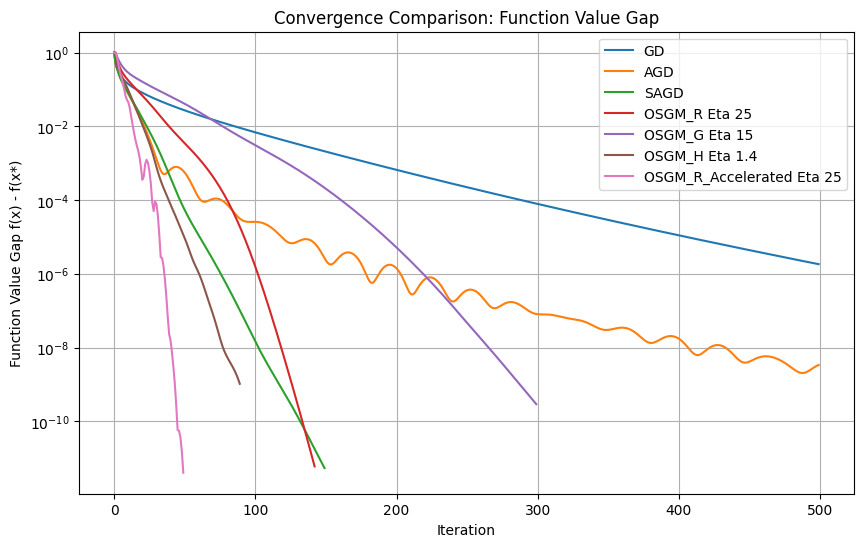

In [692]:
iterations = 500
iter = 300
i = 90
it = 150
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), gap_history_gd[:iterations], label='GD')
plt.plot(range(iterations), gap_history_agd[:iterations], label='AGD')
plt.plot(range(it), gap_history_sagd[:it], label='SAGD')

for index, eta in enumerate(eta_candidates_osgm_r):
    it_local = min(iterations, len(gap_history_osgm_r_all[index]))
    if np.any(np.isnan(gap_history_osgm_r_all[index])):
        continue
    plt.plot(range(it_local), gap_history_osgm_r_all[index][:it_local], label=f'OSGM_R Eta {eta}')

for index, eta in enumerate(eta_candidates_osgm_g):
    it_local = min(iter, len(gap_history_osgm_g_all[index]))
    if np.any(np.isnan(gap_history_osgm_g_all[index])):
        continue
    plt.plot(range(it_local), gap_history_osgm_g_all[index][:it_local], label=f'OSGM_G Eta {eta}')

for index, eta in enumerate(eta_candidates_osgm_h):
    it_local = min(i, len(gap_history_osgm_h_all[index]))
    if np.any(np.isnan(gap_history_osgm_h_all[index])):
        continue
    plt.plot(range(it_local), gap_history_osgm_h_all[index][:it_local], label=f'OSGM_H Eta {eta}')

for index, eta in enumerate(eta_candidates_osgm_r_accelerated):
    it_local = min(iterations, len(gap_history_osgm_r_all_accelerated[index]))
    if np.any(np.isnan(gap_history_osgm_r_all_accelerated[index])):
        continue
    plt.plot(range(it_local), gap_history_osgm_r_all_accelerated[index][:it_local], label=f'OSGM_R_Accelerated Eta {eta}')

plt.title('Convergence Comparison: Function Value Gap')
plt.xlabel('Iteration')
plt.ylabel('Function Value Gap f(x) - f(x*)')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()


OSGM-R converged at iteration 8147 with gradient norm 3.10e-07 and function gap 9.97e-11
OSGM-R converged at iteration 5158 with gradient norm 3.11e-07 and function gap 9.95e-11
OSGM-H converged at iteration 709 with gradient norm 9.60e-11
OSGM_R_Accelerated converged at iteration 656 with grad_norm=1.25e-05 and f_gap=5.91e-11


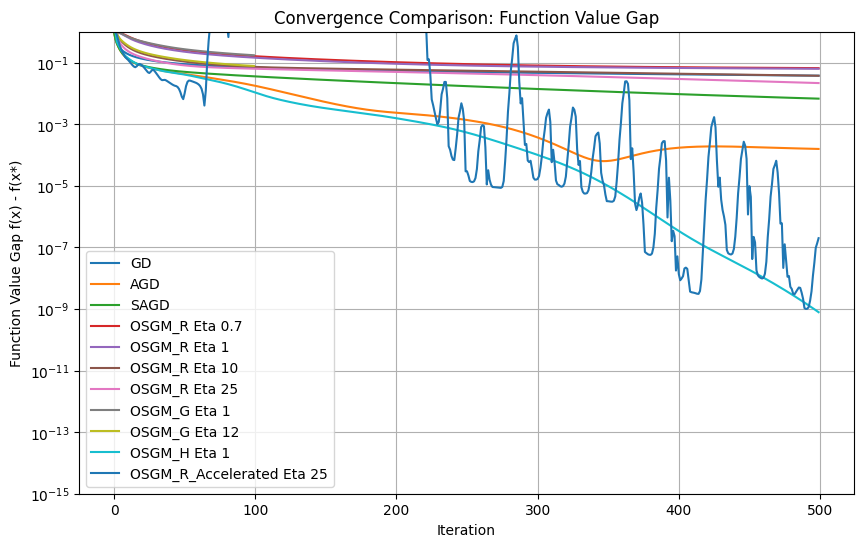

OSGM-R converged at iteration 838 with gradient norm 2.24e-06 and function gap 9.59e-11
OSGM-R converged at iteration 701 with gradient norm 2.27e-06 and function gap 9.86e-11
OSGM-R converged at iteration 223 with gradient norm 2.25e-06 and function gap 9.66e-11
OSGM-R converged at iteration 142 with gradient norm 2.23e-06 and function gap 9.42e-11
OSGM-G converged at iteration 1831 with gradient norm 9.86e-11
OSGM-H converged at iteration 182 with gradient norm 9.03e-11
GD converged at iteration 2593 with gradient norm 9.99e-11
AGD converged at iteration 2717 with gradient norm 7.82e-11
SAGD converged at iteration 261 with gradient norm 9.58e-11
OSGM_R_Accelerated converged at iteration 49 with grad_norm=1.61e-06 and f_gap=6.35e-11


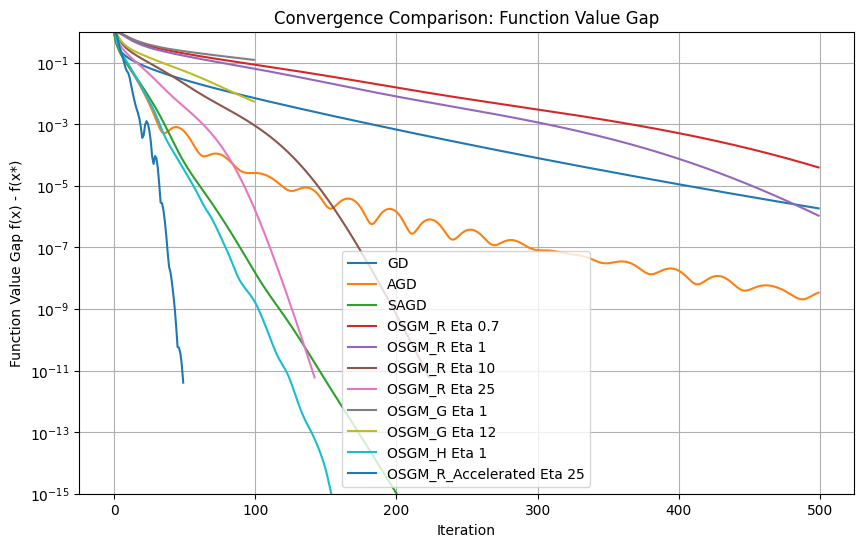

OSGM-R converged at iteration 316 with gradient norm 4.32e-06 and function gap 9.87e-11
OSGM-R converged at iteration 265 with gradient norm 4.18e-06 and function gap 9.24e-11
OSGM-R converged at iteration 85 with gradient norm 3.84e-06 and function gap 7.83e-11


<ipython-input-687-689d32530da2>:18: RuntimeWarning: overflow encountered in multiply
  surrogate_grad = - (grad * grad_next) / max(f_gap, tol)
<ipython-input-687-689d32530da2>:18: RuntimeWarning: invalid value encountered in divide
  surrogate_grad = - (grad * grad_next) / max(f_gap, tol)


OSGM-G converged at iteration 604 with gradient norm 9.99e-11
OSGM-H converged at iteration 118 with gradient norm 8.79e-11
GD converged at iteration 727 with gradient norm 9.83e-11
AGD converged at iteration 929 with gradient norm 8.46e-11
SAGD converged at iteration 211 with gradient norm 9.43e-11
OSGM_R_Accelerated converged at iteration 30 with grad_norm=8.99e-06 and f_gap=7.36e-11


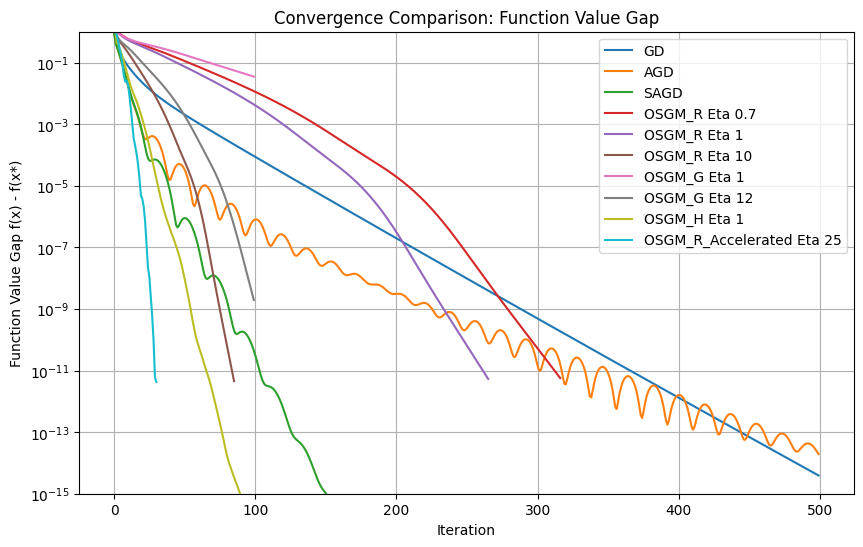

In [693]:
for i in range(0, 3):
  A, b, sigma = datasets[i]

  eta_candidates_osgm_r = [0.7,  1, 10, 25] #this parameters can be changed
  eta_candidates_osgm_g = [ 1, 12]
  eta_candidates_osgm_h = [1]
  eta_candidates_osgm_r_accelerated = [25]
  A_inv = np.linalg.inv(A)
  P_ini = np.linalg.inv(ATA)
  P_i = np.zeros((n, n))
  gap_history_osgm_r_all = []
  for eta in eta_candidates_osgm_r:
    gap_history_osgm_r= osgm_r(
        lambda x: least_squares_function(x, A, b),
        lambda x: gradient_least_squares(x, A, b),
        P_i,
        x_init,
        K,
        eta,
        f_star
    )
    gap_history_osgm_r = [g / gap_history_osgm_r[0] for g in gap_history_osgm_r]
    gap_history_osgm_r_all.append(gap_history_osgm_r)

  gap_history_osgm_g_all = []
  for eta in eta_candidates_osgm_g:
    gap_history_osgm_g= osgm_g(
        lambda x: least_squares_function(x, A, b),
        lambda x: gradient_least_squares(x, A, b),
        A,
        P_i,
        x_init,
        K,
        eta,
        f_star
    )
    gap_history_osgm_g = [g / gap_history_osgm_g[0] for g in gap_history_osgm_g]
    gap_history_osgm_g_all.append(gap_history_osgm_g)

  gap_history_osgm_h_all = []
  for eta in eta_candidates_osgm_h:
    gap_history_osgm_h= osgm_h(
        lambda x: least_squares_function(x, A, b),
        lambda x: gradient_least_squares(x, A, b),
        P_i,
        x_init,
        K,
        eta,
        f_star
    )
    gap_history_osgm_h = [g / gap_history_osgm_h[0] for g in gap_history_osgm_h]
    gap_history_osgm_h_all.append(gap_history_osgm_h)


  gap_history_gd = gd(
      lambda x: least_squares_function(x, A, b),
      lambda x: gradient_least_squares(x, A, b),
      x_init,
      K,
      L,
      f_star
  )
  gap_history_gd = [g / gap_history_gd[0] for g in gap_history_gd]


  gap_history_agd = agd(
      lambda x: least_squares_function(x, A, b),
      lambda x: gradient_least_squares(x, A, b),
      x_init,
      K,
      L,
      f_star
  )
  gap_history_agd = [g / gap_history_agd[0] for g in gap_history_agd]

  gap_history_sagd = sagd(
      lambda x: least_squares_function(x, A, b),
      lambda x: gradient_least_squares(x, A, b),
      x_init,
      K,
      L,
      mu,
      f_star
  )
  gap_history_sagd = [g / gap_history_sagd[0] for g in gap_history_sagd]

  gap_history_osgm_r_all_accelerated = []
  for eta in eta_candidates_osgm_r_accelerated:
      gap_history_osgm_r_accelerated = osgm_r_accelerated(
          A, b,
          lambda x: least_squares_function(x, A, b),
          lambda x: gradient_least_squares(x, A, b),
          P_i,
          x_init,
          K,
          eta,
          f_star
      )
      gap_history_osgm_r_accelerated = [g / gap_history_osgm_r_accelerated[0] for g in gap_history_osgm_r_accelerated]
      gap_history_osgm_r_all_accelerated.append(gap_history_osgm_r_accelerated)

  iterations = 500
  iter = 300
  it = 200
  i = 100
  plt.figure(figsize=(10, 6))

  it_local = min(iterations, len(gap_history_gd[:iterations]))
  plt.plot(range(it_local), gap_history_gd[:iterations], label='GD')
  it_local = min(iterations, len(gap_history_agd[:iterations]))
  plt.plot(range(it_local), gap_history_agd[:iterations], label='AGD')
  it_local = min(iterations, len(gap_history_sagd[:iterations]))
  plt.plot(range(it_local), gap_history_sagd[:iterations], label='SAGD')

  for index, eta in enumerate(eta_candidates_osgm_r):
      it_local = min(iterations, len(gap_history_osgm_r_all[index]))
      if np.any(np.isnan(gap_history_osgm_r_all[index])):
          continue
      plt.plot(range(it_local), gap_history_osgm_r_all[index][:it_local], label=f'OSGM_R Eta {eta}')

  for index, eta in enumerate(eta_candidates_osgm_g):
      it_local = min(i, len(gap_history_osgm_g_all[index]))
      if np.any(np.isnan(gap_history_osgm_g_all[index])):
          continue
      plt.plot(range(it_local), gap_history_osgm_g_all[index][:it_local], label=f'OSGM_G Eta {eta}')

  for index, eta in enumerate(eta_candidates_osgm_h):
      it_local = min(iterations, len(gap_history_osgm_h_all[index]))
      if np.any(np.isnan(gap_history_osgm_h_all[index])):
          continue
      plt.plot(range(it_local), gap_history_osgm_h_all[index][:it_local], label=f'OSGM_H Eta {eta}')

  for index, eta in enumerate(eta_candidates_osgm_r_accelerated):
      it_local = min(iterations, len(gap_history_osgm_r_all_accelerated[index]))
      if np.any(np.isnan(gap_history_osgm_r_all_accelerated[index])):
          continue
      plt.plot(range(it_local), gap_history_osgm_r_all_accelerated[index][:it_local], label=f'OSGM_R_Accelerated Eta {eta}')

  plt.title('Convergence Comparison: Function Value Gap')
  plt.xlabel('Iteration')
  plt.ylabel('Function Value Gap f(x) - f(x*)')
  plt.ylim((1e-15, 1))
  plt.grid(True)
  plt.yscale('log')
  plt.legend()
  plt.show()
